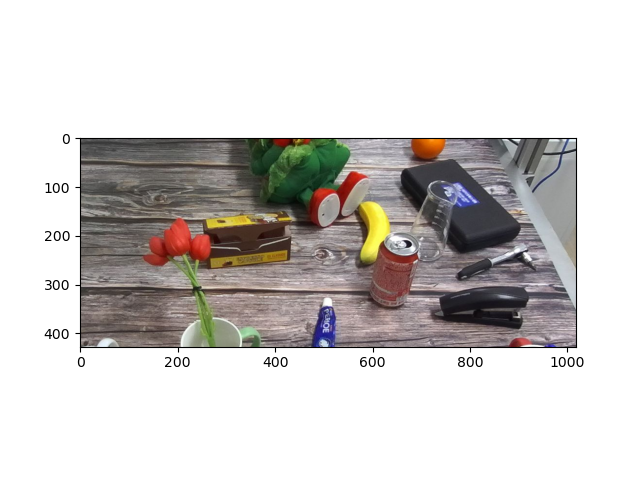

In [2]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg
from PIL import Image
import cv2

# Data processing
fig = plt.figure()
img_path = "../../../datasets/0926/1/rgb_00000.png"
depth_path = "../../../datasets/0926/1/depth_00000.npy"
extr_path = "../../../datasets/0926/1/extrinsic.npy"
intr_path = "../../../datasets/0926/1/intrinsic.npy"

img = Image.open(img_path).convert('RGB')
depth = np.load(depth_path).astype(np.float32)
extr = np.load(extr_path).astype(np.float32)
extr = extr @ np.diag([1, -1, -1, 1])
extr = np.linalg.inv(extr)
intr = np.load(intr_path).astype(np.float32)

# Lifting
H, W = depth.shape
N = H * W  # Total number of pixels

u, v = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
ones = np.ones_like(u)

pix = np.stack((u, v, ones), axis=-1).reshape(N, 3).astype(np.float32)

K_inv = np.linalg.inv(intr)  # (3, 3)
cam_coords_normalized = K_inv @ pix.T
cam_coords = cam_coords_normalized * depth.flatten().reshape(1, N)  # (3, N)


R = extr[:3, :3]
t = extr[:3, 3]  
world_coords = R.T @ (cam_coords - t.reshape(3, 1))  # (3, N)
pcd = world_coords.T.reshape(H, W, 3)

plt.imshow(img)

query_point_ls = []

def onclick(event):
    if event.xdata is None or event.ydata is None:
        return
    x_pixel = round(event.xdata)
    y_pixel = round(event.ydata)
    query_point_ls.append(pcd[y_pixel, x_pixel, :].copy())
    if(len(query_point_ls)==20):
        print(np.array(query_point_ls))
        np.save("../../../datasets/0926/video_input_query_point.npy",np.array(query_point_ls))

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)